# Etiquetado de los datos

---

En este notebook, vamos a etiquetar los datos, aplicándo una regla concreta sobre métricas de acceso que calculemos sobre los estudiantes de la asignatura. 

En concreto la regla será, que un estudiante se considera  que ha abandonado en caso de que:

- Esté 14 días sin acceder al curso
- O su último log haya sido en noviembre o antes

Para poder aplicar esta regla a los datos, debemos calcular las siguientes métricas:

- Máximo número consecutivo de días sin acceder a la plataforma
- Último acceso del estudiante al curso (fuera de periodo de exámenes)

Por lo tanto, solo será necesario utilizar la tabla que contiene todos los registros de la asignatura para obtenerlas.

## Configuración de la sesión 

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import count
from pyspark.sql.functions import from_unixtime, date_format
import os

ruta_origen = "/home/carlos/Documentos/TFG/spark-workspace/data/raw/"
ruta_destino = "/home/carlos/Documentos/TFG/spark-workspace/data/metrics/labels"
courseid_ip = 8683
os.makedirs(ruta_destino, exist_ok=True)

# Crear sesión Spark
spark = SparkSession.builder \
    .appName("Creacion de metricas de los cuestionarios") \
    .master("local[*]") \
    .config("spark.sql.shuffle.partitions", "8") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/06/05 00:14:34 WARN Utils: Your hostname, carlos-Modern-15-A11SB, resolves to a loopback address: 127.0.1.1; using 192.168.1.182 instead (on interface wlo1)
25/06/05 00:14:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/05 00:14:35 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Carga de datos y visualización

In [2]:
import shutil
import glob

df_log_ip = spark.read.parquet(f"{ruta_origen}/log_ip_cmi.parquet")

df_log_ip.printSchema()
df_log_ip.show(5, truncate=False)

num_valores = df_log_ip.select("contextinstanceid").distinct().count()
print(f"Número de valores distintos de contextinstanceid: {num_valores}")

num_valores = df_log_ip.select("courseid").distinct().count()
print(f"Número de valores distintos de courseid: {num_valores}")

df_log_ip = df_log_ip.drop("courseid")

df_log_ip.select("action").distinct().show(500, truncate=False)

# df_prueba = df_log_ip.filter(
# (col("component") == "core") &
# (col("action") == "viewed") &
# (col("contextinstanceid") == courseid_ip)
# )

# num_filas = df_prueba.count()
# print(f"Número de filas en df_prueba: {num_filas}")



root
 |-- userid: string (nullable = true)
 |-- courseid: long (nullable = true)
 |-- timecreated: long (nullable = true)
 |-- eventname: string (nullable = true)
 |-- component: string (nullable = true)
 |-- action: string (nullable = true)
 |-- contextinstanceid: long (nullable = true)

+----------------------------------------------------------------+--------+-----------+----------------------------+---------+------+-----------------+
|userid                                                          |courseid|timecreated|eventname                   |component|action|contextinstanceid|
+----------------------------------------------------------------+--------+-----------+----------------------------+---------+------+-----------------+
|3b8d431cbee3182d06225f9d5ab51f5806e8042f145e0ad0e37d98f56ae78f3d|8683    |1694535538 |\\core\\event\\course_viewed|core     |viewed|8683             |
|3b8d431cbee3182d06225f9d5ab51f5806e8042f145e0ad0e37d98f56ae78f3d|8683    |1694535588 |\\core\\event\\

## Quedarnos solo con la ventana de destino para calcular las métricas sobre ella


In [3]:
from matplotlib.pylab import f
from pyspark.sql.functions import to_date, from_unixtime

df_log_date = df_log_ip.withColumn("date", to_date(from_unixtime(col("timecreated"))))

df_log_destino = df_log_date.filter(
      (col("date") >= "2023-11-01") & (col("date") <= "2023-12-25")) \
.orderBy("date")

number_of_tuples = df_log_destino.count()
print(f"Número de tuplas en el DataFrame filtrado: {number_of_tuples}")

Número de tuplas en el DataFrame filtrado: 66886


## Calcular métricas

Dado que para ambas métricas solo se van a considerar los accesos de un estudiante al curso, primero vamos a filtrar el dataframe para quedarnos solo con aquellas entradas del log que estén asociadas a el acceso al mismo, y no a interacción con los recursos y módulos del aula. 


In [8]:
df_accesos = df_log_destino.filter(
(col("component") == "core") & # Indicar el módulo de moodle que ha registrado la entrada, en este caso al tratarse de un acceso al aula virtual debe ser core
(col("action") == "viewed") & # Indicar la acción que se ha realizado, en este caso un acceso al aula virtual
(col("contextinstanceid") == courseid_ip) #Pasar el id del curso como contextinstanceid , dado que así indicamos que el acceso ha sido al curso y no a un recurso del mismo
)

df_accesos = df_accesos.select("userid", "date")
num_accesos = df_accesos.count()
print(f"Número de accesos al curso en la ventana de destino: {num_accesos}")

Número de accesos al curso en la ventana de destino: 18120


### Máximo de días consecutivos sin acceder al aula

Para calcular esta métrica, podemos servirnos de las potentísimas funciones de ventana de pyspark

In [9]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, datediff, lag

# Paso 1: Crear ventana por alumno, ordenada por fecha de acceso
ventana = Window.partitionBy("userid").orderBy("date")

# Paso 2: Calcular diferencia de días entre fechas consecutivas
df_con_diff = df_accesos.withColumn("fecha_anterior", lag("date").over(ventana))
df_con_diff = df_con_diff.withColumn("dias_sin_acceso", datediff("date", "fecha_anterior"))

# Paso 3: Obtener el máximo salto de días por alumno
dias_maximos = df_con_diff.groupBy("userid").agg(
    max("dias_sin_acceso").alias("max_dias_sin_acceso")
)

dias_maximos.show(5, truncate = False)

+----------------------------------------------------------------+-------------------+
|userid                                                          |max_dias_sin_acceso|
+----------------------------------------------------------------+-------------------+
|006b0e7bd07cec05e0952cb61c30893f6d30d7962f9efc99d0f041f6fadcc320|9                  |
|00ded60939d4949cc46e46e865b25d3f11756733cf946087710c61eda02729e1|7                  |
|05912200993a87a89df1a6ca9ac3d6493e2c4cc178760d8ee1da41033ac01b3e|5                  |
|073b1d0ee1d3857d50ea87087b25bbc6f5dbdbd2e94bcf52b89c48afa37e8c16|7                  |
|080b2c8b65e9d941f12e62b7d2b9fa22b669f06aeed07df5683fdf93a799204d|7                  |
+----------------------------------------------------------------+-------------------+
only showing top 5 rows


Veamos cúantos estudiantes abandonaron el curso en base a este criterio

Distribución de abandono por inactividad (≥ 14 días sin acceso):
abandona_por_inactividad
No abandona    190
Sí abandona      9
Name: count, dtype: int64


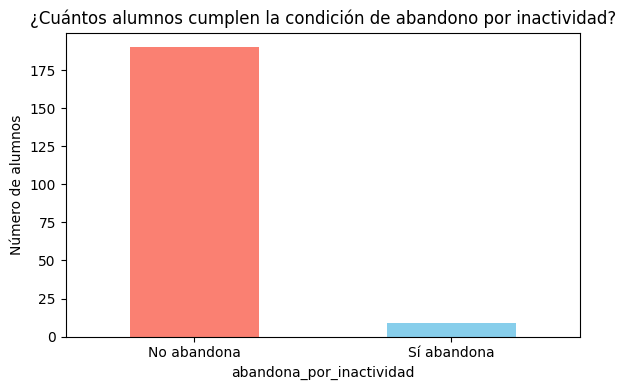

In [15]:
df_inactividad = dias_maximos.toPandas()

# Etiqueta booleana
df_inactividad["abandona_por_inactividad"] = df_inactividad["max_dias_sin_acceso"] >= 14

# Conteo de abandonos vs no abandonos
conteo = df_inactividad["abandona_por_inactividad"].value_counts().rename(index={True: "Sí abandona", False: "No abandona"})

# Mostrar distribución en consola
print("Distribución de abandono por inactividad (≥ 14 días sin acceso):")
print(conteo)

# Gráfico
plt.figure(figsize=(6, 4))
conteo.plot(kind="bar", color=["salmon", "skyblue"])
plt.title("¿Cuántos alumnos cumplen la condición de abandono por inactividad?")
plt.ylabel("Número de alumnos")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Último acceso del estudiante al curso

In [5]:
from pyspark.sql.functions import max

ultimo_acceso = df_accesos.groupBy("userid").agg(
    max("date").alias("ultima_fecha_acceso")
)
ultimo_acceso.show(5, truncate=False)


+----------------------------------------------------------------+-------------------+
|userid                                                          |ultima_fecha_acceso|
+----------------------------------------------------------------+-------------------+
|3b8d431cbee3182d06225f9d5ab51f5806e8042f145e0ad0e37d98f56ae78f3d|2023-12-25         |
|368093a57fe640879a9fc57ecb7e2c846b7dadf19620bfc9c4c001daeaf9af0f|2023-12-21         |
|b10bfb431460e96f99322635d8c44d0fb4f74302c61334119ab1c842e049fac1|2023-12-19         |
|e86f7c2d50f4fa9ee5b3f8bf9a25af4c9ef573fa28a0c8c50df815971efa0529|2023-12-20         |
|bc941ebd72011adc6a5fbaa15a85c36e9dd20fd0af0156317b764f98a7a099ee|2023-12-20         |
+----------------------------------------------------------------+-------------------+
only showing top 5 rows


Una vez calculado este valor, podemos explorar rápidamente la distribución de los valores para cada usuario, para evaluar si podría ser un buen indicador del abandono

abandona_por_ultima_fecha
Antes       193
Después       6
Name: count, dtype: int64

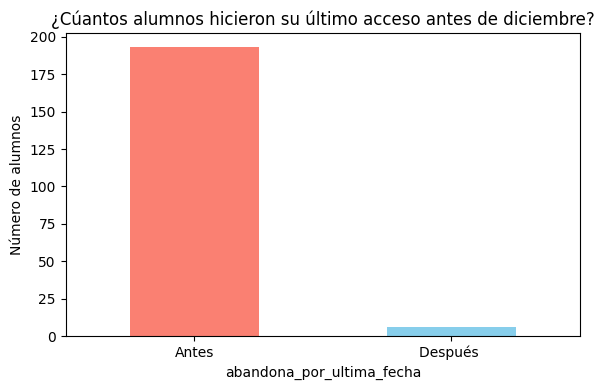

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime


# Lo conviertes a Pandas:
df_ultimo_acceso = ultimo_acceso.toPandas()

# Define la fecha límite
fecha_limite = datetime.date(2023, 11, 30)

# Crea la columna booleana con la condición de abandono
df_ultimo_acceso["abandona_por_ultima_fecha"] = df_ultimo_acceso["ultima_fecha_acceso"] <= fecha_limite

# Cuenta cuántos cumplen y cuántos no
conteo = df_ultimo_acceso["abandona_por_ultima_fecha"].value_counts().rename(index={True: "Después ", False: "Antes"})

display(conteo)

# Dibuja el gráfico
plt.figure(figsize=(6,4))
conteo.plot(kind="bar", color=["salmon", "skyblue"])
plt.title("¿Cúantos alumnos hicieron su último acceso antes de diciembre?")
plt.ylabel("Número de alumnos")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Juntar etiquetas parciales en un dataset y estudiar cruce entre reglas

Ahora que ya tenemos estas etiquetas parciales sobre cada una de las reglas establecidas, podemos crear una tabla lógica que nos indique cuantos estudiantes cumplen ambos criterios, cuales solo uno etc.


Cruce de condiciones de abandono:
   abandona_por_ultima_fecha  abandona_por_inactividad  cuenta
0                      False                     False     185
1                      False                      True       8
2                       True                     False       5
3                       True                      True       1


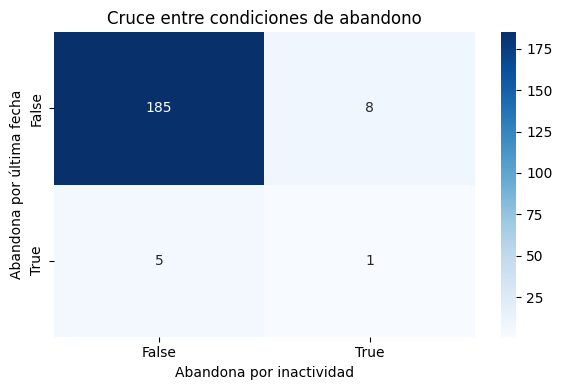

In [17]:
import seaborn as sns

# Unir ambos DataFrames para  juntar las etiquetas parciales
df_etiquetado = df_ultimo_acceso.merge(df_inactividad, on="userid", how="inner")

# Calcular el cruce
cruce = df_etiquetado.groupby(
    ["abandona_por_ultima_fecha", "abandona_por_inactividad"]
).size().reset_index(name="cuenta")

print("Cruce de condiciones de abandono:")
print(cruce)

#Visualizar como un gráfico 
tabla_cruce = pd.crosstab(
    df_etiquetado["abandona_por_ultima_fecha"],
    df_etiquetado["abandona_por_inactividad"]
)

# Gráfico
plt.figure(figsize=(6, 4))
sns.heatmap(tabla_cruce, annot=True, fmt="d", cmap="Blues")
plt.title("Cruce entre condiciones de abandono")
plt.xlabel("Abandona por inactividad")
plt.ylabel("Abandona por última fecha")
plt.tight_layout()
plt.show()



## Etiqueta final
En base a los resultados obtenidos, parece que , al haber tan poca coincidencia entre ambas etiquetas, capturan tipos diferentes de abandono. 

Esto pone de manifiesto, que el abandono no es igual para todos los estudiantes, y que se puede abandonar una asignatura de forma temporal, y que un estudiante se descuide durante un tiempo de ella, pero que no tiene por que implicar que vaya dejarla de lado completamente. 

Establecer el criterio final de abandono, depende de qué tipo de estudiante interese más detectar al docente, si tanto los que tienen periodos de inactividad, aquellos que darán de lado completamente la asignatura y no la volverán a ver...

Parece llamativo, que los estudiantes que desaparecieron de la asignatura dado que su última fecha de acceso al campus, no cumplieran mayoritariamente la condición de haber tenido periodos de dos semanas entre acceso y acceso previamente, dado que podríamos interpretar esto como que, quizás fueron muy constantes durante el curso, pero que llegado un momento, se vieron superados y dejaron de lado la asignatura, pero que hasta ese momento apenas tuvieron periodos de inactividad. 


Al haber tan poca coincidencia, **quizás merece la pena que la etiqueta final sea generada con un `OR` entre ambas condiciones**, dado que así el modelo pueda aprender a capturar patrones en más tipos de abandono.


Distribución final de abandono:
abandona
No abandona    185
Sí abandona     14
Name: count, dtype: int64


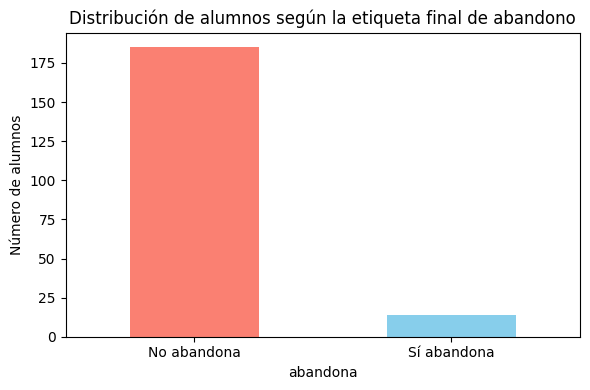

In [19]:
df_etiquetado["abandona"] = (
    df_etiquetado["abandona_por_ultima_fecha"] | df_etiquetado["abandona_por_inactividad"]
)


# Contar cuántos abandonan y cuántos no
conteo_abandono = df_etiquetado["abandona"].value_counts().rename(index={True: "Sí abandona", False: "No abandona"})

# Imprimir en consola
print("Distribución final de abandono:")
print(conteo_abandono)

# Crear gráfico de barras
plt.figure(figsize=(6, 4))
conteo_abandono.plot(kind="bar", color=["salmon", "skyblue"])
plt.title("Distribución de alumnos según la etiqueta final de abandono")
plt.ylabel("Número de alumnos")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## Exportamos a csv las etiquetas generadas


In [20]:
df_etiquetado.to_csv("/home/carlos/Documentos/TFG/spark-workspace/data/etiquetas/etiquetado_abandono.csv", index=False)